In [2]:
import pyparax as parax
import numpy as np 
import pandas as pd
import scipy as sp
from math import pi
import matplotlib.pyplot as plt
import cmath
from scipy.optimize import leastsq

In [199]:
field_center = np.loadtxt('E_20.csv',delimiter=',',dtype=complex)

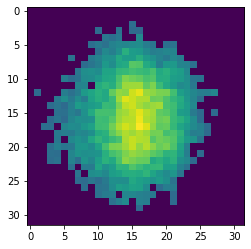

In [196]:
plt.imshow(np.abs(field_center[20-16:20+16,43-16:43+16]))

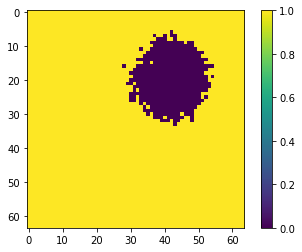

In [200]:
plt.imshow(0==np.abs(field_center))
plt.colorbar()

In [198]:
field_center = field_center[20-16:20+16,43-16:43+16]
field_center.shape

(32, 32)

In [209]:
lambda_=1.3e-10
window_extent = 3e-4
grid_dim = 64
upsize_dim = 500

In [29]:
# Function to use in the residual fit for 2D the amplitude of the beam slice which returns a 2D array evaluated at all the grid points
def gauss_beam_amplitude(x,A,x0,y0,w):
# A 2D mesh, x, describing the domain over which the amplitude is defined
# A supposed amplitude constant, A
# The center of the beam slice described by two floating point numbers, x0 and y0, for the x and y axes respectively
# The spot size, w which describes the width of the slice
    return A*np.exp(-((x[0]-x0)**2+(x[1]-y0)**2)/w**2)/w

# Associated residual to the 2D amplitude which returns a 2D array evaluated at all the grid points
def amp_residual(p,x,y):
# An array like container of parameters describing the amplitude profile, namely A,x0,y0,and w as defined by the gauss_beam_amplitude function
# A 2D mesh, x, describing the domain over which the amplitude is defined
# The data intended to be predicted, y, which is a 2D array over the domain
    A,x0,y0,w = p
    sim = gauss_beam_amplitude(x,A,x0,y0,w)
    return y-sim

# Function to use in the residual fit for 2D phase of a beam slice which returns a 2D array evaluated at all the grid points
def gauss_beam_phase(x,a,x0,y0,R):
# A 2D mesh, x, describing the domain over which the amplitude is defined
# A phase shift constant representative of the superfluous -kz + arctan(z/zR) term
# The center of the beam slice described by two floating point numbers, x0 and y0, for the x and y axes respectively
# The radius of curvature for beam slice
    return (a-pi*((x[0]-x0)**2+(x[1]-y0)**2)/(R*lambda_))

# Associated residual to the 2D phase which returns a 2D array evaluated at all the grid points
def phase_residual(p,x,y):
# An array like conatainer of parameters describing the phase profile, namely a, x0, y0, and w as defined by the gauss_beam_phase function
# A 2D mesh, x, describing the domain over which the amplitude is defined
    a,x0,y0,R = p
    sim = gauss_beam_phase(x,a,x0,y0,R)
    return y-sim

def gauss_beam_real_normal(x,a,x0,y0,R):
    return np.cos(a-pi*((x[0]-x0)**2+(x[1]-y0)**2)/(R*lambda_))

def real_normal_residual(p,x,y):
    a,x0,y0,R = p
    sim = gauss_beam_real_normal(x,a,x0,y0,R)
    return y-sim

In [30]:
def param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    var_res = np.sum((err_f(pfit,x,y))**2)/(len(y)-len(pcov))
    param_se = np.array([np.sqrt(pcov[i,i]*var_res) for i in range(len(pcov))])
    return param_se

def bootstrap_param_se(pfit,pcov,x,y,function):
    err_f = lambda pfit,x,y:y-function(x,*pfit)
    res_se = np.std(err_f(pfit,x,y))
    bootstrap_se_lst = []
    for i in range(100):
        y_random_err = np.random.normal(0,res_se,len(y))
        y_random = y+y_random_err
        random_fit,_ = leastsq(err_f,pfit,args=(x,y_random))
        bootstrap_se_lst.append(random_fit)
    param_se = np.std(np.array(bootstrap_se_lst),axis=0)
    return param_se


In [31]:
def fit_field(fi,bootstrap):
    abs_fi = np.abs(fi)
    pmf = abs_fi/np.sum(abs_fi)
    fi_window_extent = window_extent*fi.shape[0]/grid_dim
    l = np.linspace(-fi_window_extent/2,fi_window_extent/2,fi.shape[0])
    marg_x = np.sum(pmf,axis=1)
    marg_y = np.sum(pmf,axis=0)
    Ex = np.sum(marg_x*l)
    Ey = np.sum(marg_y*l)
    x_mesh, y_mesh  = np.meshgrid(l,l)
    x = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
    
    #p0_amp = [1,Ex,Ey,fi_window_extent]
    p0_amp = [np.max(abs_fi)*fi_window_extent,Ex,Ey,fi_window_extent]
    y_amp = abs_fi.flatten()
    pfit_amp, pcov_amp = leastsq(amp_residual,x0=p0_amp,args=(x,y_amp),full_output=1)[:2]    
    p0_phase = [1,Ex,Ey,1e3]
    #pfit_phase, pcov_phase = leastsq(phase_residual,x0=p0_phase,args=(x,np.unwrap(np.angle(fi)).flatten()))
    #real_norm = np.real(fi)/abs_fi
    y_phase = np.unwrap(np.angle(fi)).flatten()
    pfit_phase, pcov_phase = leastsq(phase_residual,x0=p0_phase,args=(x,y_phase),full_output=1)[:2]
        
    if np.all(pcov_amp != None) and np.all(pcov_phase != None):
        if bootstrap:
            pse_phase = bootstrap_param_se(pfit_phase,pcov_phase,x,y_phase,gauss_beam_phase)
            pse_amp = bootstrap_param_se(pfit_amp,pcov_amp,x,y_amp,gauss_beam_amplitude)
        else:
            pse_phase = param_se(pfit_phase,pcov_phase,x,y_phase,gauss_beam_phase)
            pse_amp = param_se(pfit_amp,pcov_amp,x,y_amp,gauss_beam_amplitude)
        return pfit_amp,pfit_phase,pse_amp,pse_phase
    else:    
        return np.nan*np.ones(4),np.nan*np.ones(4),np.nan*np.ones(4),np.nan*np.ones(4)

def prop_fit(E,upsize_dim=upsize_dim,prop_len=40000,step_size=1000,full_output=False,bootstrap=False):
    parax.numeric_parameters.wavelength = lambda_*1000
    parax.numeric_parameters.dx = 1000*window_extent/(grid_dim)
    parax.numeric_parameters.dy = 1000*window_extent/(grid_dim)
    parax.numeric_parameters.dz = step_size
    # Number of points on the x and y axes
    parax.numeric_parameters.N_x = upsize_dim
    parax.numeric_parameters.N_y = upsize_dim
    f0 = 1j*np.zeros((upsize_dim,upsize_dim))
    center = E.reshape((grid_dim,grid_dim))
    f0[upsize_dim//2-grid_dim//2:upsize_dim//2+grid_dim//2,upsize_dim//2-grid_dim//2:upsize_dim//2+grid_dim//2] = center
    fit_amp_lst = []
    fit_phase_lst = []
    se_amp_lst = []
    se_phase_lst = []
    bounds_lst = []
    system = [prop_len]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
    for i,fi in enumerate(fgauss_beam_phase():
        adjusted_dim = grid_dim+i*5
        lower_bound = (upsize_dim-adjusted_dim)//2
        upper_bound = (upsize_dim+adjusted_dim)//2
        fi_subset = fi[lower_bound:upper_bound,lower_bound:upper_bound]
        fit_amp,fit_phase,se_amp,se_phase = fit_field(fi_subset,bootstrap)
        fit_amp_lst.append(fit_amp)
        fit_phase_lst.append(fit_phase)
        se_amp_lst.append(se_amp)
        se_phase_lst.append(se_phase)
        bounds_lst.append([lower_bound,upper_bound])
    if full_output:
        return fit_amp_lst,fit_phase_lst,se_amp_lst,se_phase_lst,bounds_lst,f
    else:
        return fit_amp_lst,fit_phase_lst,se_amp_lst,se_phase_lst,bounds_lst

In [190]:
fit_amp_lst,fit_phase_lst,se_amp_lst,se_phase_lst,bounds_lst,f=prop_fit(field_center.flatten(),full_output=True,bootstrap=True)

[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/40
Step 1/40
Step 2/40
Step 3/40
Step 4/40
Step 5/40
Step 6/40
Step 7/40
Step 8/40
Step 9/40
Step 10/40
Step 11/40
Step 12/40
Step 13/40
Step 14/40
Step 15/40
Step 16/40
Step 17/40
Step 18/40
Step 19/40
Step 20/40
Step 21/40
Step 22/40
Step 23/40
Step 24/40
Step 25/40
Step 26/40
Step 27/40
Step 28/40
Step 29/40
Step 30/40
Step 31/40
Step 32/40
Step 33/40
Step 34/40
Step 35/40
Step 36/40
Step 37/40
Step 38/40
Step 39/40


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)


### Check Fucntion fit

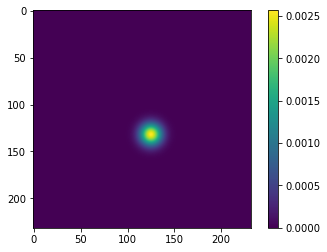

In [199]:
k = 40
fi_window_extent = window_extent*(grid_dim+k*5)/grid_dim
l = np.linspace(-fi_window_extent/2,fi_window_extent/2,grid_dim+k*5)
x_mesh, y_mesh  = np.meshgrid(l,l)
x = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
plt.imshow(gauss_beam_amplitude(x,*fit_amp_lst[k]).reshape((grid_dim+k*5,grid_dim+k*5)))
plt.colorbar()

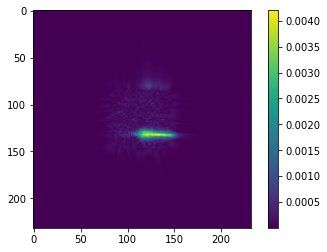

In [200]:
plt.imshow(np.abs(f[k])[bounds_lst[k][0]:bounds_lst[k][1],bounds_lst[k][0]:bounds_lst[k][1]])
plt.colorbar()

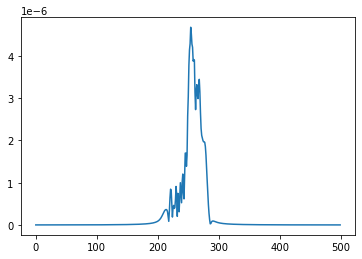

In [243]:
plt.plot(np.abs(f[k])[60,:])

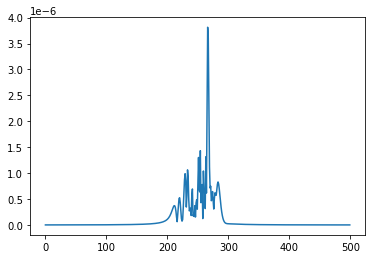

In [242]:
plt.plot(np.abs(f[k])[:,60])

### Fit Propagation Profile 2D

In [32]:
def wz_fit(z,w0,z0,wavelen):
    zR = pi*w0**2/wavelen
    return w0*(1+((z-z0)/zR)**2)**0.5

def wz_residual(p,z,w):
    w0,z0,wavelen = p
    w_hat = wz_fit(z,w0,z0,wavelen)
    return w-w_hat

def get_w0(w_arr,full_output=False,step_size=1000,bootstrap=False):
    z = [i*step_size/1000 for i,w in enumerate(w_arr) if np.logical_not(np.isnan(w))]
    w = w_arr[np.logical_not(np.isnan(w_arr))]
    p0 = [0.01,1,lambda_]
    pfit,pcov = leastsq(wz_residual,p0,args=(z,w),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,z,w,wz_fit)
    else:
        pse = param_se(pfit,pcov,z,w,wz_fit)
    if full_output:
        plt.plot(z,np.abs(w))
        plt.plot(z,wz_fit(z,*pfit))
        plt.xlabel('$\Delta z$ (m)')
        plt.ylabel('$w(z)$ (m)')
        return pfit,pse
    else:
        return pfit,pse
    

/tmp/ipykernel_7267/924929148.py:4: RuntimeWarning: invalid value encountered in sqrt
  param_se = np.array([np.sqrt(pcov[i,i]*var_res) for i in range(len(pcov))])


(array([ 4.84478811e-09, -9.79315774e+00, -3.83579925e-14]),
 array([       nan, 8.09297335,        nan]))

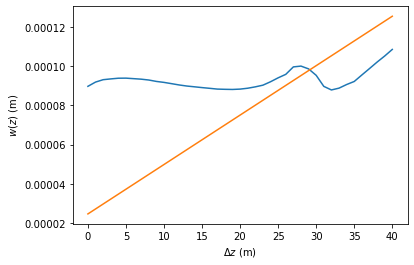

In [240]:
fit_w0,se_w0 = get_w0(np.array(fit_amp_lst)[:,3],full_output=True)
fit_w0,se_w0

Text(0, 0.5, '$w$ (m)')

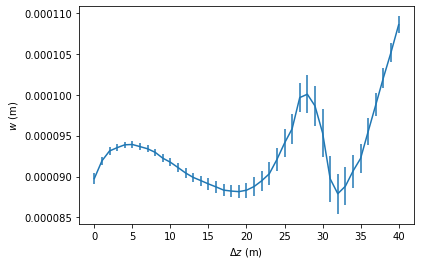

In [275]:
plt.errorbar(np.arange(41),np.abs(np.array(fit_amp_lst)[:,3]),yerr=np.array(se_amp_lst)[:,3])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w$ (m)')

This tells us the amplitude fit is working roughly correctly if the wavelength is coming back to us roughly as the same order of magnitude.

In [33]:
def Rz_fit(z,w0,z0,wavelen):
    zR = pi*w0**2/wavelen
    return (z-z0)*(1+(zR/(z-z0))**2)

def Rz_residual(p,z,R):
    w0,z0,wavelen = p
    Rz_hat = Rz_fit(z,w0,z0,wavelen)
    return R - Rz_hat

def get_Rz_fit(R_arr,full_output=False,bootstrap=False,step_size=1000):
    z = [i*step_size/1000 for i,R in enumerate(R_arr) if np.logical_not(np.isnan(R))]
    R = R_arr[np.logical_not(np.isnan(R_arr))]
    p0 = [1e-5,-1.5,lambda_]
    pfit,pcov = leastsq(Rz_residual,p0,args=(z,R),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,z,R,Rz_fit)
    else:
        pse = param_se(pfit,pcov,z,R,Rz_fit)
    if full_output:
        plt.plot(z,R)
        plt.plot(z,Rz_fit(z,*pfit))
        plt.xlabel('$\Delta z$  (m)')
        plt.ylabel('$R(z)$  (m)')
        return pfit,pse
    else:
        return pfit,pse


(array([ 1.49427567e-05, -6.90672249e-03,  1.86333129e-11]),
 array([4.91480987e-07, 1.52611404e-03, 1.13993871e-12]))

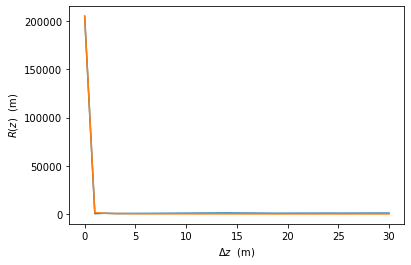

In [66]:
fit_Rz,se_Rz = get_Rz_fit(np.array(fit_phase_lst)[7:,3],full_output=True,bootstrap=True)
fit_Rz,se_Rz

<ErrorbarContainer object of 3 artists>

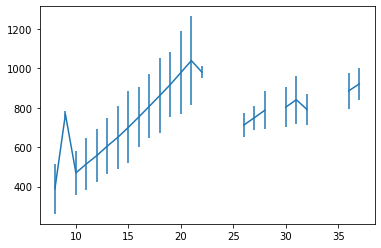

In [63]:
plt.errorbar(np.arange(8,81),np.array(fit_phase_lst)[8:,3],yerr=np.array(se_phase_lst)[8:,3])

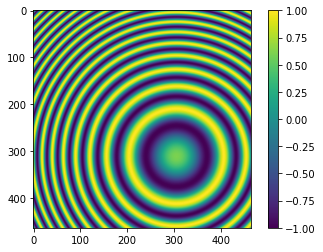

In [172]:
k = 80
fi_window_extent = window_extent*(64+k*5)/grid_dim
l = np.linspace(-fi_window_extent/2,fi_window_extent/2,64+k*5)
x_mesh, y_mesh  = np.meshgrid(l,l)
x = np.vstack((x_mesh.flatten(),y_mesh.flatten()))
plt.imshow(gauss_beam_real(x,*fit_phase_lst[k]).reshape((64+k*5,64+k*5)))
plt.colorbar()

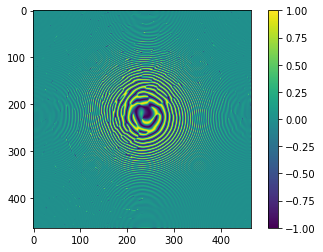

In [173]:
plt.imshow(np.cos(np.angle((f[k][bounds_lst[k][0]:bounds_lst[k][1],bounds_lst[k][0]:bounds_lst[k][1]]))))
plt.colorbar()

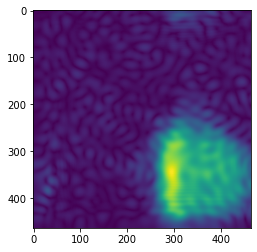

In [174]:
plt.imshow(np.abs(f[k][bounds_lst[k][0]:bounds_lst[k][1],bounds_lst[k][0]:bounds_lst[k][1]]))

### Fit 1D for Separate Axes

In [202]:
def get_amp_i_fit(marg_pmf,l,bootstrap):
    Ei = np.sum(marg_pmf*l)
    p0 = [1e-5,Ei,1e-5]
    pfit,pcov = leastsq(marg_residual,p0,args=(l,marg_pmf),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,l,marg_pmf,marg_fit)
    else:
        pse = param_se(pfit,pcov,l,marg_pmf,marg_fit)
        
    if np.all(pfit!=None):
        return pfit,pse
    else:
        return np.nan*np.ones(3),np.nan*np.ones(3)

def marg_residual(p,x,marg_pmf):
    A,x0,w = p
    marg_hat = marg_fit(x,A,x0,w)
    return marg_pmf - marg_hat

def marg_fit(x,A,x0,w):
    return A*np.exp(-(x-x0)**2/w**2)/w



In [203]:
def get_phase_i_fit(phase_slice,l,bootstrap):
    p0 = [150,l[np.argmax(phase_slice)],10]
    pfit,pcov = leastsq(phase_i_residual,p0,args=(l,phase_slice),full_output=1)[:2]
    if bootstrap:
        pse = bootstrap_param_se(pfit,pcov,l,phase_slice,phase_i_fit)
    else:
        pse = param_se(pfit,pcov,l,phase_slice,phase_i_fit)
        
    if np.all(pfit!=None):
        return pfit,pse
    else:
        return np.nan*np.ones(3),np.nan*np.ones(3)

def phase_i_residual(p,x,phase_i):
    a,x0,R = p
    phase_i_hat = phase_i_fit(x,a,x0,R)
    diff = phase_i - phase_i_hat
    return diff

def phase_i_fit(x,a,x0,R):
    return a - pi*(x-x0)**2/(R*lambda_)

In [204]:
def fit_astigmatic_field(fi,bootstrap):
    abs_fi = np.abs(fi)
    pmf = abs_fi/np.sum(abs_fi)
    fi_window_extent = window_extent*fi.shape[0]/grid_dim
    l = np.linspace(-fi_window_extent/2,fi_window_extent/2,fi.shape[0])
    marg_x = np.sum(pmf,axis=0)
    marg_y = np.sum(pmf,axis=1)
    pfit_amp_x,pse_amp_x = get_amp_i_fit(marg_x,l,bootstrap)
    pfit_amp_y,pse_amp_y = get_amp_i_fit(marg_y,l,bootstrap) 
    phase_plot = np.unwrap(np.angle(fi))
    Ex = np.sum(l*marg_x)
    Ey = np.sum(l*marg_y)
    Ex_index = int(Ex/fi_window_extent*fi.shape[0])+fi.shape[0]//2
    Ey_index = int(Ey/fi_window_extent*fi.shape[0])+fi.shape[0]//2
    pfit_phase_x,pse_phase_x = get_phase_i_fit(phase_plot[Ey_index,:],l,bootstrap)
    pfit_phase_y,pse_phase_y = get_phase_i_fit(phase_plot[:,Ex_index],l,bootstrap)
    # pfit_phase_x_lst = []
    # pfit_phase_y_lst = []
    # for phase_slice_x,phase_slice_y in zip(phase_plot,phase_plot.T):
    #     pfit_phase_xi = get_phase_i_fit(phase_slice_x,l)
    #     pfit_phase_yi = get_phase_i_fit(phase_slice_y,l)
    #     pfit_phase_x_lst.append(pfit_phase_xi)
    #     pfit_phase_y_lst.append(pfit_phase_yi)
    # pfit_phase_x = np.mean(np.array(pfit_phase_x_lst),axis=0)
    # pfit_phase_y = np.mean(np.array(pfit_phase_y_lst),axis=0)
    return pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y,pfit_phase_x,pse_phase_x,pfit_phase_y,pse_phase_y

def prop_astigmatic_fit(E,upsize_dim=upsize_dim,prop_len=80000,step_size=1000,full_output=False,bootstrap=False):
    parax.numeric_parameters.wavelength=lambda_*1000
    parax.numeric_parameters.dx = 1000*window_extent/grid_dim
    parax.numeric_parameters.dy = 1000*window_extent/grid_dim
    parax.numeric_parameters.dz = step_size
    parax.numeric_parameters.N_x = upsize_dim
    parax.numeric_parameters.N_y = upsize_dim
    parax.numeric_parameters.N_z = prop_len//step_size
    f0 = 1j*np.zeros((upsize_dim,upsize_dim))
    center = E.reshape((grid_dim,grid_dim))
    f0[(upsize_dim - grid_dim)//2:(upsize_dim + grid_dim)//2,(upsize_dim - grid_dim)//2:(upsize_dim + grid_dim)//2] = center
    system = [prop_len]
    f = parax.experimental_simulator.experimental_simulator_2d.propagate(f0, system, output_full = True, forward = False, print_output=True)
    bounds_lst = []
    fit_amp_x_lst = []
    fit_amp_y_lst = []
    fit_phase_x_lst = []
    fit_phase_y_lst = []
    se_amp_x_lst = []
    se_amp_y_lst = []
    se_phase_x_lst = []
    se_phase_y_lst = []
    for i,fi in enumerate(f):
        adjusted_dim = int(grid_dim + i*5*step_size/1000)
        lower_bound = (upsize_dim - adjusted_dim)//2
        upper_bound = (upsize_dim + adjusted_dim)//2
        fi_subset = fi[lower_bound:upper_bound,lower_bound:upper_bound]
        pfit_amp_x,pse_amp_x,pfit_amp_y,pse_amp_y,pfit_phase_x,pse_phase_x,pfit_phase_y,pse_phase_y = fit_astigmatic_field(fi,bootstrap)
        fit_amp_x_lst.append(pfit_amp_x)
        fit_amp_y_lst.append(pfit_amp_y)
        fit_phase_x_lst.append(pfit_phase_x)
        fit_phase_y_lst.append(pfit_phase_y)
        se_amp_x_lst.append(pse_amp_x)
        se_amp_y_lst.append(pse_amp_y)
        se_phase_x_lst.append(pse_phase_x)
        se_phase_y_lst.append(pse_phase_y)
        bounds_lst.append([lower_bound,upper_bound])
    if full_output:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst,f
    else:
        return fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst

In [205]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst,f = prop_astigmatic_fit(field_center.flatten(),bootstrap=True,full_output=True,step_size=250,prop_len=20000,upsize_dim)

[['normal', 'normal']]
Propagate for 20000 units [mm]
Step 0/80
Step 1/80
Step 2/80
Step 3/80
Step 4/80
Step 5/80
Step 6/80
Step 7/80
Step 8/80
Step 9/80
Step 10/80
Step 11/80
Step 12/80
Step 13/80
Step 14/80
Step 15/80
Step 16/80
Step 17/80
Step 18/80
Step 19/80
Step 20/80
Step 21/80
Step 22/80
Step 23/80
Step 24/80
Step 25/80
Step 26/80
Step 27/80
Step 28/80
Step 29/80
Step 30/80
Step 31/80
Step 32/80
Step 33/80
Step 34/80
Step 35/80
Step 36/80
Step 37/80
Step 38/80
Step 39/80
Step 40/80
Step 41/80
Step 42/80
Step 43/80
Step 44/80
Step 45/80
Step 46/80
Step 47/80
Step 48/80
Step 49/80
Step 50/80
Step 51/80
Step 52/80
Step 53/80
Step 54/80
Step 55/80
Step 56/80
Step 57/80
Step 58/80
Step 59/80
Step 60/80
Step 61/80
Step 62/80
Step 63/80
Step 64/80
Step 65/80
Step 66/80
Step 67/80
Step 68/80
Step 69/80
Step 70/80
Step 71/80
Step 72/80
Step 73/80
Step 74/80
Step 75/80
Step 76/80
Step 77/80
Step 78/80
Step 79/80


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


Text(0, 0.5, '$w_x(z)$ (m)')

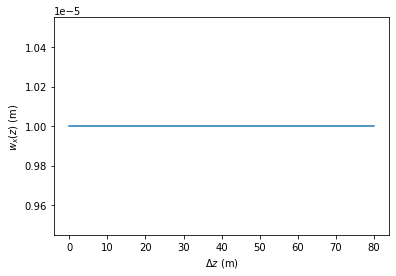

In [207]:
plt.plot(np.array(fit_amp_x_lst)[:,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_x(z)$ (m)')

Text(0, 0.5, '$w_y(z)$ (m)')

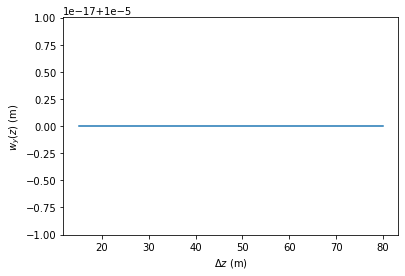

In [206]:
plt.errorbar(np.arange(81)[15:],np.array(fit_amp_y_lst)[15:,2],yerr=np.array(se_amp_y_lst)[15:,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_y(z)$ (m)')

w0y = 1.2076173720144284e-05 , z0y = 13.869996968637595 , wavelen = 1.3e-10


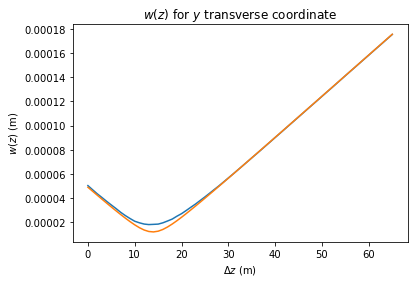

In [91]:
fit_w0y, se_w0y = get_w0(np.array(fit_amp_y_lst)[15:,2],bootstrap=True,full_output=True)
plt.title('$w(z)$ for $y$ transverse coordinate')
w0y,z0y = fit_w0y
print('w0y =',w0y, ', z0y =',z0y,  ', wavelen =',lambda_ )

In [249]:
se_w0y

array([1.43838764e-07, 4.31333499e-02, 1.54472414e-12])

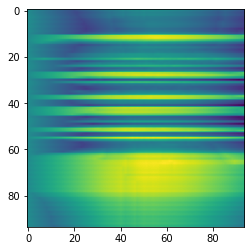

In [151]:
plt.imshow(np.unwrap(np.angle(f[6][bounds_lst[6][0]:bounds_lst[6][1],bounds_lst[6][0]:bounds_lst[6][1]])))

w0x = 3.133608716220465e-05 , z0x = -7.509989225934401 , wavelen = 6.12780959666531e-10


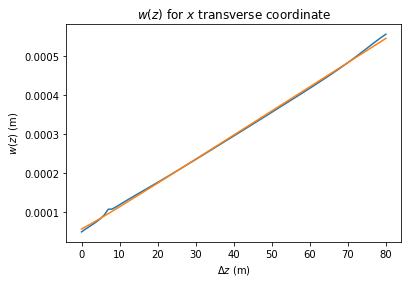

In [77]:
fit_w0x, se_w0x = get_w0(np.array(fit_amp_x_lst)[:,2],full_output=True)
plt.title('$w(z)$ for $x$ transverse coordinate')
w0x,z0x,wavelen = fit_w0x
print('w0x =', w0x, ', z0x =',z0x,  ', wavelen =',wavelen )

The phase information being in the large R value range for the transverse x direction seems to give us another route for estimating $w_{0x}$ and $z_{0x}$

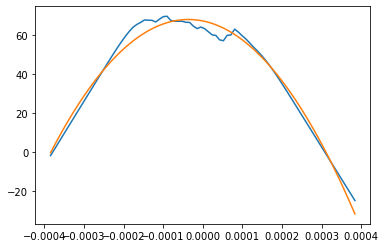

In [252]:
k = 10
fi_window_extent = window_extent*(grid_dim+k*5)/grid_dim
l = np.linspace(-fi_window_extent/2,fi_window_extent/2,grid_dim+k*5)
lower_bound = bounds_lst[k][0]
upper_bound = bounds_lst[k][1]
pfit,pse = get_phase_i_fit(np.unwrap(np.angle(f[k][lower_bound:upper_bound,lower_bound:upper_bound]))[-10+(upper_bound-lower_bound)//2,:],l,bootstrap=True)
plt.plot(l,np.unwrap(np.angle(f[k][lower_bound:upper_bound,lower_bound:upper_bound]))[-10+(upper_bound-lower_bound)//2,:])
plt.plot(l,phase_i_fit(l,*pfit))

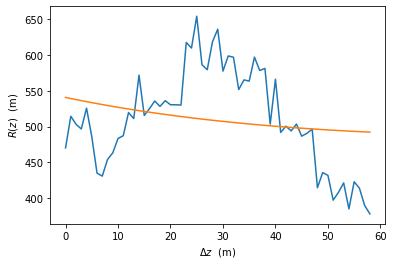

In [253]:
fit_Rzy,se_Rzy = get_Rz_fit(np.array(fit_phase_y_lst)[1:60,2],full_output=True)
#plt.ylim(0,1000)

/tmp/ipykernel_7267/924929148.py:4: RuntimeWarning: invalid value encountered in sqrt
  param_se = np.array([np.sqrt(pcov[i,i]*var_res) for i in range(len(pcov))])


(0.0, 100000.0)

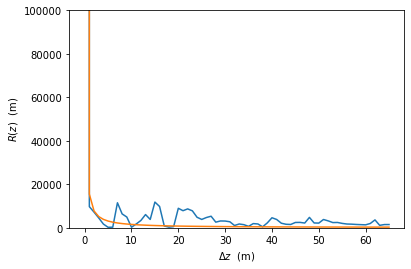

In [269]:
fit_Rzx,se_Rzx = get_Rz_fit(np.array(fit_phase_x_lst)[15:,2],full_output=True)
plt.ylim(0,100000)

In [270]:
fit_Rzx,se_Rzx

(array([ 1.29614274e-05, -4.29298181e-04,  4.24059873e-12]),
 array([           nan, 8.02753116e-05,            nan]))

(0.0, 100000.0)

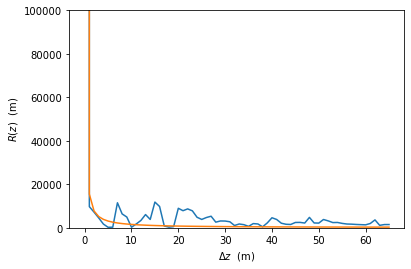

In [273]:
fit_Rzx_bootstrap,se_Rzx_bootstrap = get_Rz_fit(np.array(fit_phase_x_lst)[15:,2],full_output=True,bootstrap=True)
plt.ylim(0,100000)

In [274]:
fit_Rzx_bootstrap,se_Rzx_bootstrap

(array([ 1.29614274e-05, -4.29298181e-04,  4.24059873e-12]),
 array([2.56599974e-07, 6.29007504e-05, 1.61894629e-13]))

### Calculate Alternate Hyperparams for Other Dimension

In [30]:
def curvature_profile(z,w0,z0,full_output=False):
    zR = pi*w0**2/lambda_
    eta = w0/zR
    t = (z-z0)/zR
    t = t[t>0]
    kappa = (1/zR)*eta/(1+(eta**2+1)*t**2)**(3/2)
    if full_output:
        plt.plot(t,kappa)
        plt.xlabel('t')
        plt.ylabel('$\kappa$ ($m^{-1}$)')
        return kappa, t
    else:
        return kappa, t

def get_backwards_extent(kappaR,z0,w0):
    zR = pi*w0**2/lambda_
    eta = w0/zR
    tR = np.sqrt(((eta/(zR*kappaR))**(3/2)-1)/(eta**2+1))
    return tR*zR + z0 

def get_w_curvature_profile(wz,step_size=1000,full_output=False):
    z = [i*step_size/1000 for i,w in enumerate(wz) if not np.isnan(w)]
    pfit,pse = get_w0(wz,full_output=False,bootstrap=True)
    kappa = curvature_profile(z,pfit[0],pfit[1],full_output=full_output)
    return kappa
    

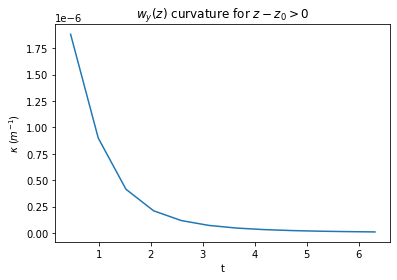

In [675]:
kappa_wy, t_wy = get_w_curvature_profile(np.array(fit_amp_y_lst)[:20,2],full_output=True)
plt.title('$w_y(z)$ curvature for $z-z_0>0$')
plt.savefig('wy_curvature.png')

In [709]:
get_backwards_extent(kappa_wy[-1],6+fit_Rzx[1],3.2*fit_Rzx[0])

50.78108044607654

In [135]:
prop_len = 40000
step_size = 1000

In [136]:
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst,f = prop_astigmatic_fit(field_center.flatten(),full_output=True,bootstrap=True,step_size=step_size,prop_len=prop_len)

[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/40
Step 1/40
Step 2/40
Step 3/40
Step 4/40
Step 5/40
Step 6/40
Step 7/40
Step 8/40
Step 9/40
Step 10/40
Step 11/40
Step 12/40
Step 13/40
Step 14/40
Step 15/40
Step 16/40
Step 17/40
Step 18/40
Step 19/40
Step 20/40
Step 21/40
Step 22/40
Step 23/40
Step 24/40
Step 25/40
Step 26/40
Step 27/40
Step 28/40
Step 29/40
Step 30/40
Step 31/40
Step 32/40
Step 33/40
Step 34/40
Step 35/40
Step 36/40
Step 37/40
Step 38/40
Step 39/40


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


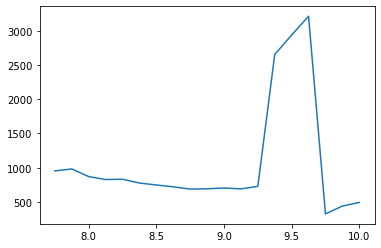

In [249]:
plt.plot(step_size/1000*np.arange(81)[62:],np.array(fit_phase_x_lst)[62:,2])

<ErrorbarContainer object of 3 artists>

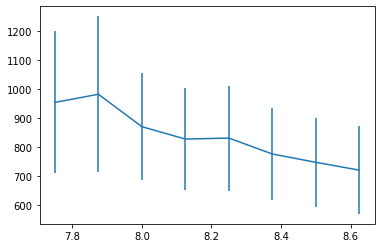

In [ ]:
plt.errorbar(step_size/1000*np.arange(81)[62:70],np.array(fit_phase_x_lst)[62:70,2],yerr=np.array(se_phase_x_lst)[62:70,2])

<ErrorbarContainer object of 3 artists>

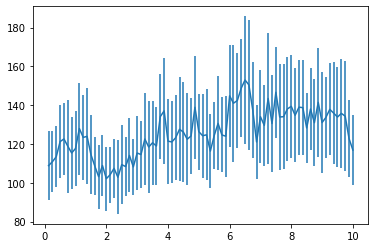

In [250]:
plt.errorbar(step_size/1000*np.arange(81)[1:],np.array(fit_phase_y_lst)[1:,2],yerr=np.array(se_phase_y_lst)[1:,2])

/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


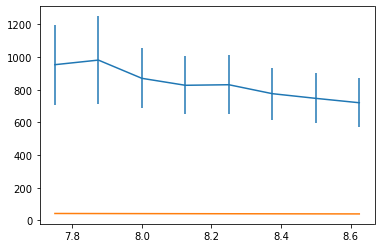

In [252]:
plt.errorbar(step_size/1000*np.arange(81)[62:70],np.array(fit_phase_x_lst)[62:70,2],yerr=np.array(se_phase_x_lst)[62:70,2])
Rzx_fit,Rzx_se =get_Rz_fit(np.array(fit_phase_x_lst)[61:,2],step_size=step_size,bootstrap=True)
plt.plot(step_size/1000*np.arange(81)[62:70],Rz_fit(step_size/1000*np.arange(81)[62:70],*Rzx_fit))

In [253]:
Rzx_fit,Rzx_se

(array([ 1.31868486e-05, -6.13333790e-05,  3.33992357e-11]),
 array([7.10737381e-07, 2.24202309e-05, 3.45387159e-12]))

Text(0, 0.5, '$w_x$ (m)')

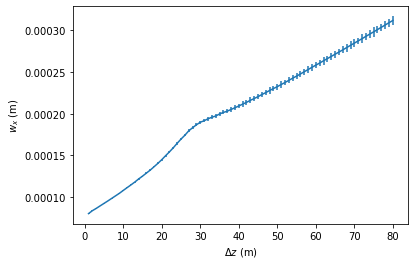

In [293]:
plt.errorbar(step_size/1000*np.arange(81)[1:],np.array(fit_amp_x_lst)[1:,2],yerr=np.array(se_amp_x_lst)[1:,2])
plt.xlabel('$\Delta z$ (m)')
plt.ylabel('$w_x$ (m)')

<ErrorbarContainer object of 3 artists>

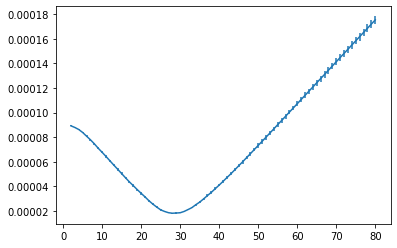

In [291]:
plt.errorbar(step_size/1000*np.arange(81)[2:],np.array(fit_amp_y_lst)[2:,2],yerr=np.array(se_amp_y_lst)[2:,2])

In [90]:
wy_fit,wy_se = get_w0(np.array(fit_amp_y_lst)[3:,2],bootstrap=True,full_output=True,step_size=step_size)

NameError: name 'step_size' is not defined

In [130]:
wy_fit,wy_se

(array([6.28964466e-06, 5.21525490e+00, 1.92652529e-10]),
 array([1.53852243e-07, 5.69620886e-03, 4.70217928e-12]))

### Test effect of Hyperparams

In [94]:
# hyperparams_lst contains 2 element arrays with propagation length and step size
def hyperparam_search_harness(field_center, hyperparams_lst,full_output=True,bootstrap=True):
    wy_results = []
    wy_results_err = []
    for hyperparams in hyperparams_lst:
        fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst = prop_astigmatic_fit(field_center,upsize_dim=upsize_dim,full_output=False,bootstrap=bootstrap,step_size=hyperparams[1],prop_len=hyperparams[0])
        lower_cutoff = int(0.02*40000/hyperparams[1])
        wy_fit,wy_se = get_w0(np.array(fit_amp_y_lst)[1+lower_cutoff:,2],bootstrap=bootstrap,full_output=False,step_size=hyperparams[1])
        wy_fit[1] = wy_fit[1] + (1+lower_cutoff)*hyperparams[1]/1000
        wy_results.append(wy_fit)
        wy_results_err.append(wy_se)
    if full_output:
        plt.figure(figsize=(12,6))
        plt.subplot(1,2,1)
        plt.errorbar(np.arange(len(wy_results)),np.array(wy_results)[:,0],yerr=np.array(wy_results_err)[:,0],linestyle='',marker='o')
        plt.ylabel('$w_{0y}$ (m)')
        plt.xticks(np.arange(len(hyperparams_lst)),[str(hyperparams) for hyperparams in hyperparams_lst])
        plt.subplot(1,2,2)
        plt.errorbar(np.arange(len(wy_results)),np.array(wy_results)[:,1],yerr=np.array(wy_results_err)[:,1],linestyle='',marker='o')
        plt.ylabel('$z_{0y}$ (m)')
        plt.xticks(np.arange(len(hyperparams_lst)),[str(hyperparams) for hyperparams in hyperparams_lst])
        return wy_results,wy_results_err
    else:
        return wy_results,wy_results_err
        

[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/20
Step 1/20
Step 2/20
Step 3/20
Step 4/20
Step 5/20
Step 6/20
Step 7/20
Step 8/20
Step 9/20
Step 10/20
Step 11/20
Step 12/20
Step 13/20
Step 14/20
Step 15/20
Step 16/20
Step 17/20
Step 18/20
Step 19/20


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/40
Step 1/40
Step 2/40
Step 3/40
Step 4/40
Step 5/40
Step 6/40
Step 7/40
Step 8/40
Step 9/40
Step 10/40
Step 11/40
Step 12/40
Step 13/40
Step 14/40
Step 15/40
Step 16/40
Step 17/40
Step 18/40
Step 19/40
Step 20/40
Step 21/40
Step 22/40
Step 23/40
Step 24/40
Step 25/40
Step 26/40
Step 27/40
Step 28/40
Step 29/40
Step 30/40
Step 31/40
Step 32/40
Step 33/40
Step 34/40
Step 35/40
Step 36/40
Step 37/40
Step 38/40
Step 39/40
[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/80
Step 1/80
Step 2/80
Step 3/80
Step 4/80
Step 5/80
Step 6/80
Step 7/80
Step 8/80
Step 9/80
Step 10/80
Step 11/80
Step 12/80
Step 13/80
Step 14/80
Step 15/80
Step 16/80
Step 17/80
Step 18/80
Step 19/80
Step 20/80
Step 21/80
Step 22/80
Step 23/80
Step 24/80
Step 25/80
Step 26/80
Step 27/80
Step 28/80
Step 29/80
Step 30/80
Step 31/80
Step 32/80
Step 33/80
Step 34/80
Step 35/80
Step 36/80
Step 37/80
Step 38/80
Step 39/80
Step 40/80
Step 41/80
Step 42/80

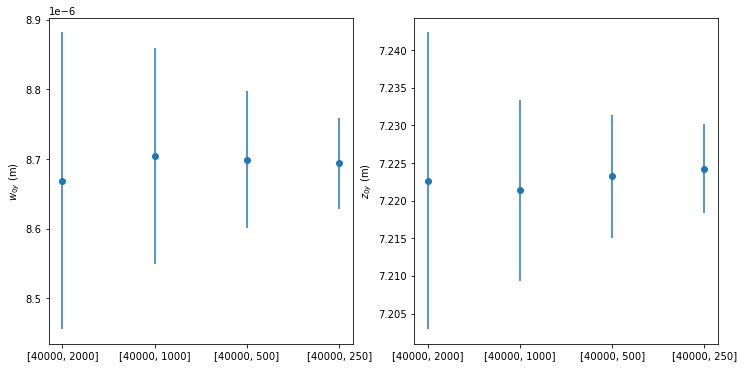

In [95]:
hyperparams_lst = [[40000,2000],[40000,1000],[40000,500],[40000,250]]
wy_res,wy_res_err = hyperparam_search_harness(field_center.flatten(),hyperparams_lst)

### Apply to Data Set

In [148]:
def fit_set(field_center_lst,full_output=True,bootstrap=True,astigmatic=True,step_size=1000,prop_len=40000):
    if astigmatic:
        fit_x_lst = []
        fit_x_err_lst = []
        fit_y_lst = []
        fit_y_err_lst = []
        for field_center in field_center_lst:
            fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst = prop_astigmatic_fit(field_center.flatten(),upsize_dim=upsize_dim,full_output=False,bootstrap=bootstrap,step_size=step_size,prop_len=prop_len)
            # Gets rid of the first data points which aren't continuous 
            lower_cutoff = int(0.05*prop_len/step_size)
            wx_fit,wx_se = get_w0(np.array(fit_amp_x_lst)[1+lower_cutoff:,2],bootstrap=bootstrap,full_output=False,step_size=step_size)
            wy_fit,wy_se = get_w0(np.array(fit_amp_y_lst)[1+lower_cutoff:,2],bootstrap=bootstrap,full_output=False,step_size=step_size)
            wy_fit[1] = wy_fit[1] + (1+lower_cutoff)*step_size/1000       
            wx_fit[1] = wx_fit[1] + (1+lower_cutoff)*step_size/1000
            fit_x_lst.append(wx_fit)
            fit_x_err_lst.append(wx_se)
            fit_y_lst.append(wy_fit)
            fit_y_err_lst.append(wy_se)
        if full_output:
            fit_display_2p(fit_x_lst,fit_x_err_lst,fit_y_lst,fit_y_err_lst)
            return [fit_x_lst,fit_y_lst],[fit_x_err_lst,fit_y_err_lst]
        else:
            return [fit_x_lst,fit_y_lst],[fit_x_err_lst,fit_y_err_lst]
    else:
        fit_lst = []
        fit_err_lst = []
        for field_center in field_center_lst:
            fit_amp_lst,fit_phase_lst,se_amp_lst,se_phase_lst,bounds_lst=prop_fit(field_center.flatten(),full_output=False,bootstrap=bootstrap,step_size=step_size,prop_len=prop_len)
            w_fit,w_se = get_w0(np.array(fit_amp_lst)[1:,2],bootstrap=bootstrap,full_output=False,step_size=step_size)
            fit_lst.append(w_fit)
            fit_err_lst.append(w_se)
        if full_output:
            fit_display_1p(fit_lst,fit_err_lst)
            return fit_lst,fit_err_lst
        else:
            return fit_lst,fit_err_lst
        

In [142]:
def fit_display_1p(fit_lst,fit_err_lst):
    fit_lst = np.array(fit_lst)
    fit_err_lst = np.array(fit_err_lst)
    plt.figure(figsize=(12,8))
    plt.subplot(1,2,1)
    plt.errorbar(np.arange(len(fit_lst)),fit_lst[:,0],yerr=fit_err_lst[:,0])
    plt.ylabel('$w_0$ (m)')
    plt.subplot(1,2,2)
    plt.errorbar(np.arange(len(fit_lst)),fit_lst[:,1],yerr=fit_err_lst[:,1])
    plt.ylabel('$z_0$ (m)')
    pass

def fit_display_2p(fit_x_lst,fit_x_err_lst,fit_y_lst,fit_y_err_lst):
    fit_x_lst = np.array(fit_x_lst)
    fit_x_err_lst = np.array(fit_x_err_lst)
    fit_y_lst = np.array(fit_y_lst)
    fit_y_err_lst = np.array(fit_y_err_lst)
    plt.figure(figsize=(15,15))
    plt.subplot(2,2,1)
    plt.errorbar(np.arange(len(fit_x_lst)),fit_x_lst[:,0],yerr=fit_x_err_lst[:,0])
    plt.ylabel('$w_{0x}$ (m)')
    plt.subplot(2,2,2)
    plt.errorbar(np.arange(len(fit_x_lst)),fit_x_lst[:,1],yerr=fit_x_err_lst[:,1])
    plt.ylabel('$z_{0x}$ (m)')
    plt.subplot(2,2,3)
    plt.errorbar(np.arange(len(fit_y_lst)),fit_y_lst[:,0],yerr=fit_y_err_lst[:,0])
    plt.ylabel('$w_{0y}$ (m)')
    plt.subplot(2,2,4)
    plt.errorbar(np.arange(len(fit_y_lst)),fit_y_lst[:,1],yerr=fit_y_err_lst[:,1])
    plt.ylabel('$z_{0y}$ (m)')
    pass


    

### Simple Test on Two Data points

In [ ]:
field_center_lst = []
field_center_lst.append(np.loadtxt('E_20.csv', delimiter=',',dtype=complex))
field_center_lst.append(np.loadtxt('E_21.csv', delimiter=',',dtype=complex))

[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/40
Step 1/40
Step 2/40
Step 3/40
Step 4/40
Step 5/40
Step 6/40
Step 7/40
Step 8/40
Step 9/40
Step 10/40
Step 11/40
Step 12/40
Step 13/40
Step 14/40
Step 15/40
Step 16/40
Step 17/40
Step 18/40
Step 19/40
Step 20/40
Step 21/40
Step 22/40
Step 23/40
Step 24/40
Step 25/40
Step 26/40
Step 27/40
Step 28/40
Step 29/40
Step 30/40
Step 31/40
Step 32/40
Step 33/40
Step 34/40
Step 35/40
Step 36/40
Step 37/40
Step 38/40
Step 39/40


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


[['normal', 'normal']]
Propagate for 40000 units [mm]
Step 0/40
Step 1/40
Step 2/40
Step 3/40
Step 4/40
Step 5/40
Step 6/40
Step 7/40
Step 8/40
Step 9/40
Step 10/40
Step 11/40
Step 12/40
Step 13/40
Step 14/40
Step 15/40
Step 16/40
Step 17/40
Step 18/40
Step 19/40
Step 20/40
Step 21/40
Step 22/40
Step 23/40
Step 24/40
Step 25/40
Step 26/40
Step 27/40
Step 28/40
Step 29/40
Step 30/40
Step 31/40
Step 32/40
Step 33/40
Step 34/40
Step 35/40
Step 36/40
Step 37/40
Step 38/40
Step 39/40


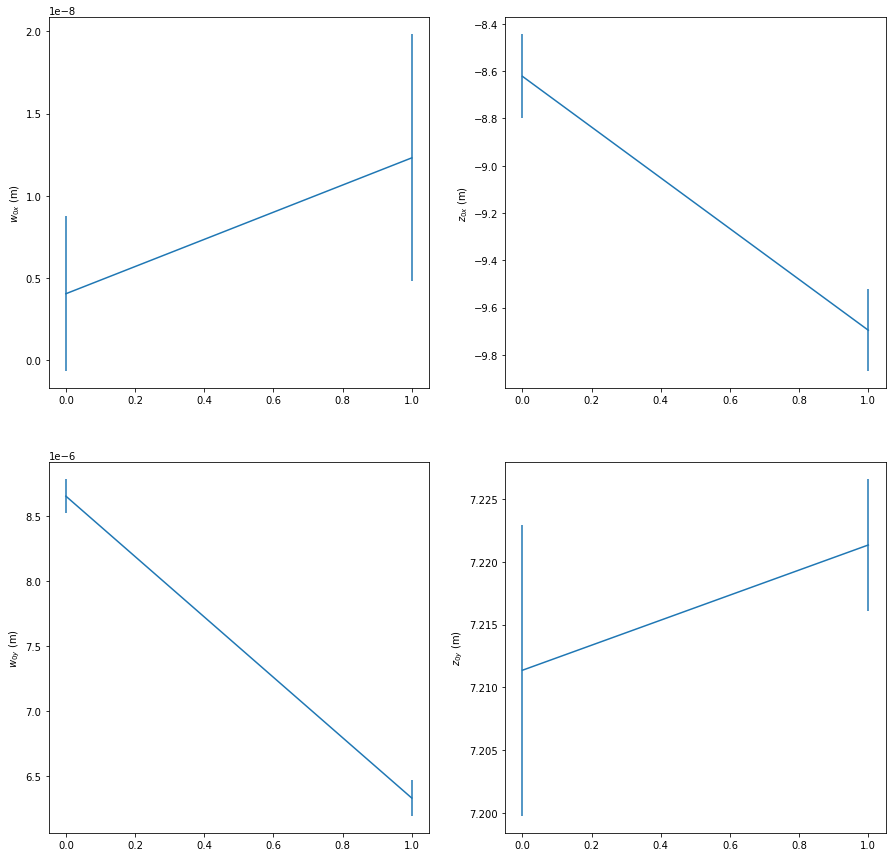

In [143]:
fit_lst,fit_err_lst = fit_set(field_center_lst)

### Separate Pulse Analysis

In [13]:
field_center = np.loadtxt('E_2pulse.csv', delimiter=',',dtype=complex)

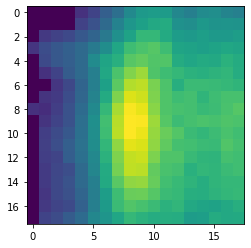

In [22]:
plt.imshow(np.abs(field_center[32-9:32+9,:18]))

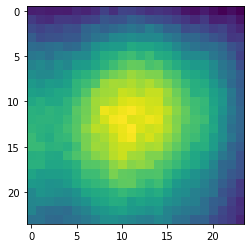

In [23]:
plt.imshow(np.abs(field_center[32-12:32+12,32-14:32+10]))

In [177]:
grid_dim = 18
upsize_dim = 250
field_left_peak = field_center[32-9:32+9,:18]
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst,f = prop_astigmatic_fit(field_left_peak.flatten(),bootstrap=True,full_output=True)

[['normal', 'normal']]
Propagate for 80000 units [mm]
Step 0/80
Step 1/80
Step 2/80
Step 3/80
Step 4/80
Step 5/80
Step 6/80
Step 7/80
Step 8/80
Step 9/80
Step 10/80
Step 11/80
Step 12/80
Step 13/80
Step 14/80
Step 15/80
Step 16/80
Step 17/80
Step 18/80
Step 19/80
Step 20/80
Step 21/80
Step 22/80
Step 23/80
Step 24/80
Step 25/80
Step 26/80
Step 27/80
Step 28/80
Step 29/80
Step 30/80
Step 31/80
Step 32/80
Step 33/80
Step 34/80
Step 35/80
Step 36/80
Step 37/80
Step 38/80
Step 39/80
Step 40/80
Step 41/80
Step 42/80
Step 43/80
Step 44/80
Step 45/80
Step 46/80
Step 47/80
Step 48/80
Step 49/80
Step 50/80
Step 51/80
Step 52/80
Step 53/80
Step 54/80
Step 55/80
Step 56/80
Step 57/80
Step 58/80
Step 59/80
Step 60/80
Step 61/80
Step 62/80
Step 63/80
Step 64/80
Step 65/80
Step 66/80
Step 67/80
Step 68/80
Step 69/80
Step 70/80
Step 71/80
Step 72/80
Step 73/80
Step 74/80
Step 75/80
Step 76/80
Step 77/80
Step 78/80
Step 79/80


/home/buzz/anaconda3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 800.
  warnings.warn(errors[info][0], RuntimeWarning)


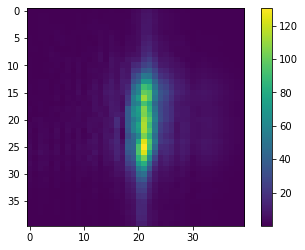

In [158]:
k = 54
plt.imshow(np.abs(f[k][230:270,235:275]))#[bounds_lst[k][0]:bounds_lst[k][1],bounds_lst[k][0]:bounds_lst[k][1]]))
plt.colorbar()

Text(0.5, 1.0, '$w_x(z)$ for left peak')

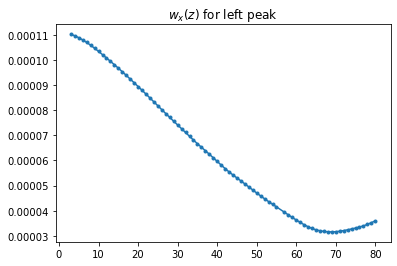

In [184]:
delta_z = np.concatenate((np.arange(3,56),np.arange(57,len(fit_amp_x_lst))))
w_xz = np.concatenate((np.array(fit_amp_x_lst)[3:56,2],np.array(fit_amp_x_lst)[57:,2]))
plt.plot(delta_z,w_xz,'.-')
plt.title('$w_x(z)$ for left peak')

(array([3.15895274e-05, 1.08688664e+01, 1.74788057e-10]),
 array([8.22724616e-08, 9.30344198e-02, 2.44068978e-12]))

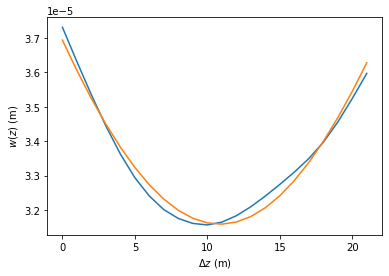

In [150]:
fit_w0,se_w0 = get_w0(np.concatenate((np.array(fit_amp_x_lst)[3:56,2],np.array(fit_amp_x_lst)[57:,2]))[55:],bootstrap=True,full_output=True)
fit_w0,se_w0

Text(0.5, 1.0, '$w_y(z)$ for left peak')

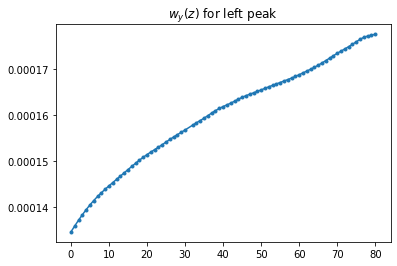

In [186]:
delta_z = np.concatenate((np.arange(31),np.arange(32,len(fit_amp_y_lst))))
w_yz = np.concatenate((np.array(fit_amp_y_lst)[:31,2],np.array(fit_amp_y_lst)[32:,2]))
plt.plot(delta_z,w_yz,'.-')
plt.title('$w_y(z)$ for left peak')

(array([ 2.73874290e-08, -2.95388526e+02,  4.15169168e-14]),
 array([1.37994435e-08, 4.86956073e+00, 2.09467601e-14]))

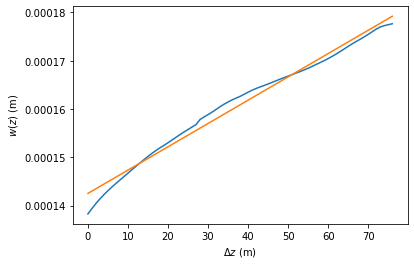

In [182]:
fit_w0,se_w0 = get_w0(w_yz,bootstrap=True,full_output=True)
fit_w0,se_w0

In [161]:
grid_dim = 24
upsize_dim = 250
field_center_peak = field_center[32-12:32+12,32-14:32+10]
fit_amp_x_lst,se_amp_x_lst,fit_amp_y_lst,se_amp_y_lst,fit_phase_x_lst,se_phase_x_lst,fit_phase_y_lst,se_phase_y_lst,bounds_lst,f = prop_astigmatic_fit(field_center_peak.flatten(),bootstrap=True,full_output=True)

[['normal', 'normal']]
Propagate for 80000 units [mm]
Step 0/80
Step 1/80
Step 2/80
Step 3/80
Step 4/80
Step 5/80
Step 6/80
Step 7/80
Step 8/80
Step 9/80
Step 10/80
Step 11/80
Step 12/80
Step 13/80
Step 14/80
Step 15/80
Step 16/80
Step 17/80
Step 18/80
Step 19/80
Step 20/80
Step 21/80
Step 22/80
Step 23/80
Step 24/80
Step 25/80
Step 26/80
Step 27/80
Step 28/80
Step 29/80
Step 30/80
Step 31/80
Step 32/80
Step 33/80
Step 34/80
Step 35/80
Step 36/80
Step 37/80
Step 38/80
Step 39/80
Step 40/80
Step 41/80
Step 42/80
Step 43/80
Step 44/80
Step 45/80
Step 46/80
Step 47/80
Step 48/80
Step 49/80
Step 50/80
Step 51/80
Step 52/80
Step 53/80
Step 54/80
Step 55/80
Step 56/80
Step 57/80
Step 58/80
Step 59/80
Step 60/80
Step 61/80
Step 62/80
Step 63/80
Step 64/80
Step 65/80
Step 66/80
Step 67/80
Step 68/80
Step 69/80
Step 70/80
Step 71/80
Step 72/80
Step 73/80
Step 74/80
Step 75/80
Step 76/80
Step 77/80
Step 78/80
Step 79/80


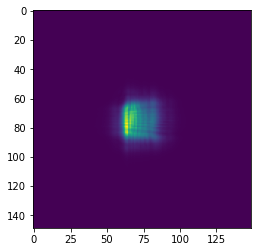

In [171]:
k = 25
plt.imshow(np.abs(f[k][bounds_lst[k][0]:bounds_lst[k][1],bounds_lst[k][0]:bounds_lst[k][1]]))

(array([ 1.33753122e-04, -1.78926583e+01,  6.84745195e-10]),
 array([8.77162530e-07, 1.83606863e+00, 1.54701539e-11]))

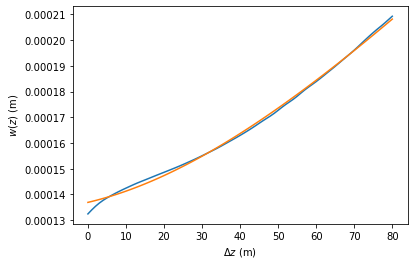

In [63]:
fit_w0,se_w0 = get_w0(np.array(fit_amp_x_lst)[:,2],bootstrap=True,full_output=True)
fit_w0,se_w0

Text(0.5, 1.0, '$w_x(z)$ for middle peak')

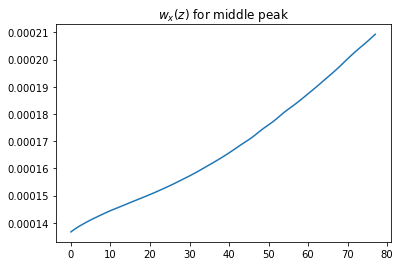

In [174]:
plt.plot(np.array(fit_amp_x_lst)[3:,2])
plt.title('$w_x(z)$ for middle peak')

(array([ 2.46756857e-08, -1.04139758e+02,  9.65773835e-14]),
 array([1.49679090e-08, 2.42156879e-01, 5.85965936e-14]))

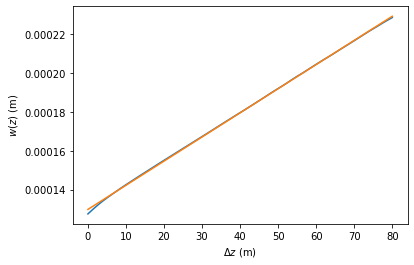

In [62]:
fit_w0,se_w0 = get_w0(np.array(fit_amp_y_lst)[:,2],bootstrap=True,full_output=True)
fit_w0,se_w0

Text(0.5, 1.0, '$w_y(z)$ for middle peak')

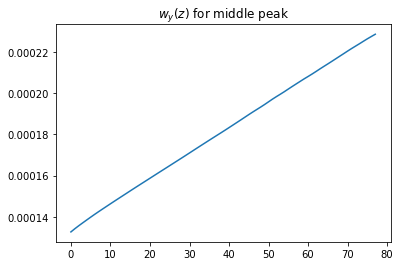

In [175]:
plt.plot(np.array(fit_amp_y_lst)[3:,2])
plt.title('$w_y(z)$ for middle peak')

spline cubic or interpolate